## Example: Horizontal line with Von Karman spectrum

In [1]:
import numpy as np 
import os
import matplotlib.pyplot as plt
from yawisi.parameters import SimulationParameters
from yawisi.wind_field import WindField
from yawisi.display import display_points
from yawisi.spectrum import Spectrum
from yawisi.locations import Locations, Grid
from yawisi.kernels import CoherenceKernel
from yawisi.wind import Wind
from tqdm import tqdm

### reading parameters

In [15]:
filename =  "config.ini"
params = SimulationParameters(filename)

In [30]:
print(params.sigma_1)

2.6


### Displaying locations

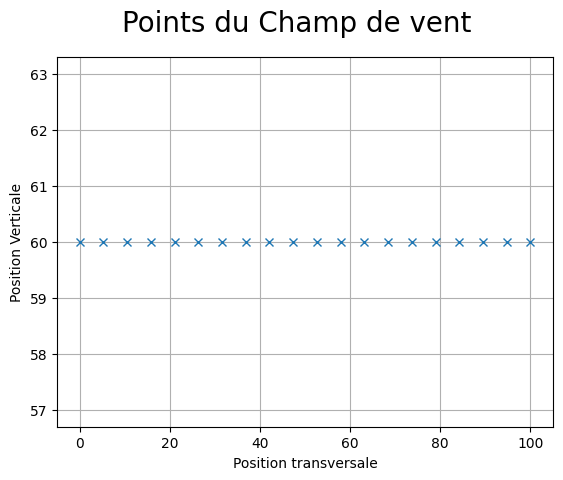

In [3]:
grid = Locations.create("grid", ny=(params.ny), nz=(params.nz), ymin=(params.ymin), ymax=(params.ymax), zmin=(params.zmin), zmax=(params.zmax))
display_points(grid)

### Generating the wind field 

In [16]:
wind_field = WindField(params)
wind_field.compute()

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:00<00:00, 45592.90it/s]


In [ ]:
from yawisi.display import  display_field
pts = [
            (0, 60), 
            (50, 60)
        ]
wind_field.locations = Locations.create("points")
wind_field.locations.add_points(pts)
display_field(wind_field=wind_field)

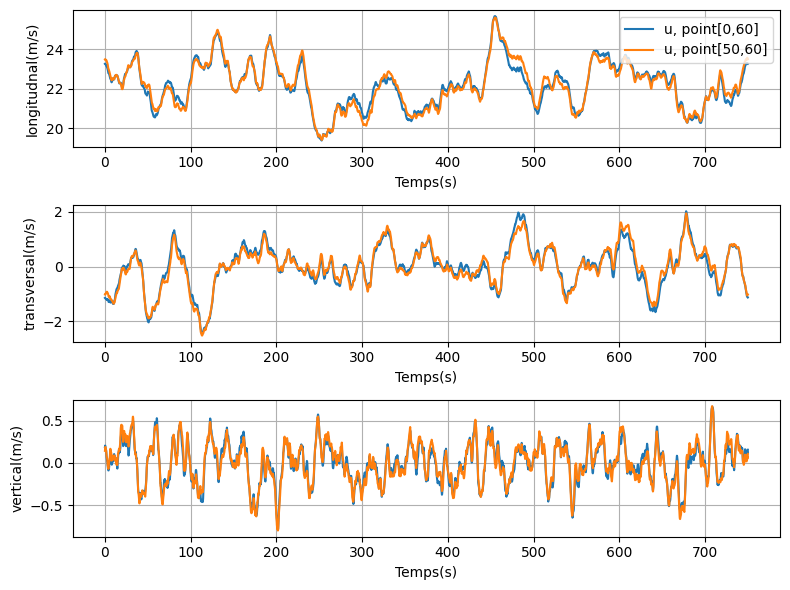

In [18]:
fig = plt.figure(figsize=(8, 6))

# Create subplots for each wind component
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Loop over wind field locations and plot wind components in each subplot
for i, (pt, wind) in enumerate(zip(wind_field.locations.points, wind_field.wind)):
    Time = [float(ii) * wind_field.params.sample_time for ii in range(wind_field.params.n_samples)]

    # Plot w_x in the first subplot (ax1)
    ax1.plot(Time, wind.wind_values[:, 0], label="u, point[%s,%s]" % (pt[0], pt[1]))

    # Plot w_y in the second subplot (ax2)
    ax2.plot(Time, wind.wind_values[:, 1], label="v, point[%s,%s]" % (pt[0], pt[1]))

    # Plot w_z in the third subplot (ax3)
    ax3.plot(Time, wind.wind_values[:, 2], label="w, point[%s,%s]" % (pt[0], pt[1]))

# Set labels and title for each subplot
ax1.set_ylabel("longitudnal(m/s)")
ax1.set_xlabel("Temps(s)")
ax1.legend()
ax1.grid()

ax2.set_ylabel("transversal(m/s)")
ax2.set_xlabel("Temps(s)")
ax2.grid()

ax3.set_ylabel("vertical(m/s)")
ax3.set_xlabel("Temps(s)")
ax3.grid()

plt.tight_layout()
plt.show()

### Standard deviation

In [19]:
wind_field.locations = Locations.create("grid", ny=(params.ny), nz=(params.nz), ymin=(params.ymin), ymax=(params.ymax), zmin=(params.zmin), zmax=(params.zmax))
ts = wind_field.get_uvwt()

In [20]:

std_u = np.std(ts[0, :, :, 0], axis=0 )
std_v = np.std(ts[1, :, :, 0], axis=0 )
std_w = np.std(ts[2, :, :, 0], axis=0 )

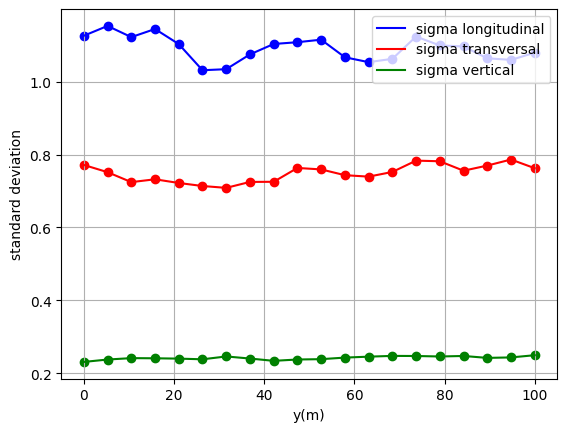

In [21]:
y = np.linspace (0, 100, 20)
plt.figure()
plt.plot(y, std_u, color='b', label='sigma longitudinal')
plt.scatter(y, std_u, color='b')
plt.plot(y, std_v, color='r', label='sigma transversal')
plt.scatter(y, std_v, color='r')
plt.plot(y, std_w, color='g', label='sigma vertical')
plt.scatter(y, std_w, color='g')
plt.grid(True)
plt.xlabel("y(m)")
plt.ylabel("standard deviation")
plt.legend(loc="upper right")
plt.show()

### Turbulence intensity

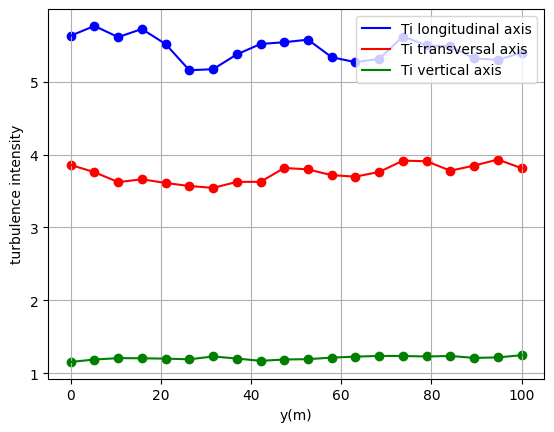

In [22]:
U_target = 20
Iu = std_u / U_target * 100
Iv =  std_v / U_target * 100
Iw = std_w / U_target * 100 
plt.figure()
plt.plot(y, Iu, color='b', label='Ti longitudinal axis')
plt.scatter(y, Iu, color='b')
plt.plot(y, Iv, color='r', label='Ti transversal axis')
plt.scatter(y, Iv, color='r')
plt.plot(y, Iw, color='g', label='Ti vertical axis')
plt.scatter(y, Iw, color='g')
plt.grid(True)
plt.xlabel("y(m)")
plt.ylabel("turbulence intensity")
plt.legend(loc="upper right")
plt.show()

### Comparison with Von Karman

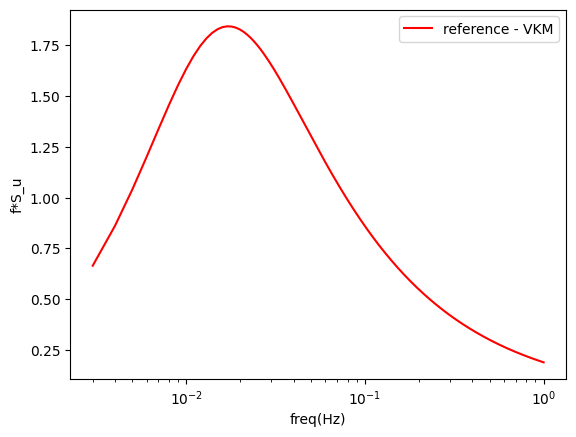

In [27]:
Lu_target = 170
Lv_target = 100
Lw_target = 35
stdU_target = 2.6
stdV_target = 2.2
stdW_target = 1.56
U_target = 20
def ref_von_karman(f):
    x = (Lu_target/U_target) * f 
    y = (Lv_target/U_target) * f 
    z = (Lw_target/U_target) * f 

    denom_x = (1 + 70.0*(x**2)) ** (5/6)
    su_ref = ((4 * Lu_target * (stdU_target)**2) /U_target) / denom_x
    denom_y = (1 + 70.0*4*(y**2)) ** (11/6)
    sv_ref = (((4 * Lv_target * (stdV_target)**2) /U_target) * (1+188.4*4*(y**2))) / denom_y
    denom_z = (1 + 70.0*4*(z**2)) ** (11/6)
    sw_ref = (((4 * Lw_target * (stdW_target)**2) /U_target) * (1+188.4*4*(z**2)))/ denom_z
    return su_ref, sv_ref, sw_ref

f = np.linspace(0.003, 1, 1000)
su_ref, sv_ref, sw_ref = ref_von_karman(f)

plt.figure()
plt.plot(f, (f*su_ref.T), color='r', label="reference - VKM")
# plt.plot(f,su, color='r')
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_u")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

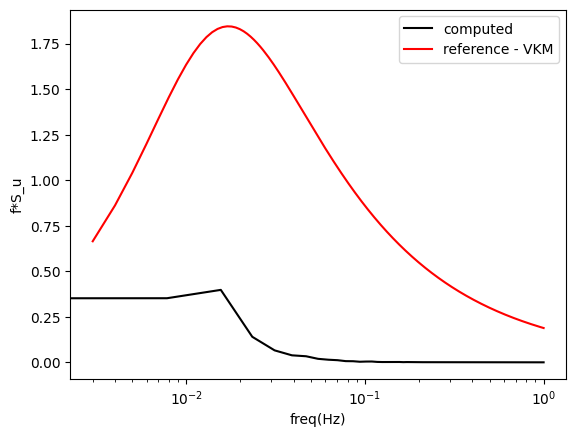

In [33]:
from scipy.signal import welch
fs = 0.1
nperseg = 1
ts = wind_field.get_uvwt()
u = ts[0]
v = ts[1]
w = ts[2]
F, SU = welch(u[:, 9, 0], fs=2)
# SU.mean()
# SU = np.mean(SU, axis=1)
# # f, SU = welch(u, fs=fs, nperseg=nperseg, noverlap=nperseg // 2) 
plt.figure()
plt.plot(F, (F*SU.T), color='k', label="computed")
plt.plot(f, (f*su_ref.T), color='r', label="reference - VKM")
# plt.plot(f,su, color='r')
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_u")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

In [24]:
u.mean()

22.1913894413569

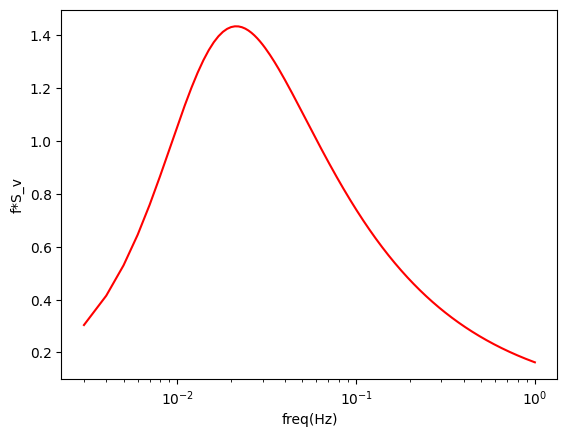

In [29]:
plt.figure()
plt.plot(f, (f*sv_ref.T), color='r')
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_v")
plt.xscale("log")
plt.show()

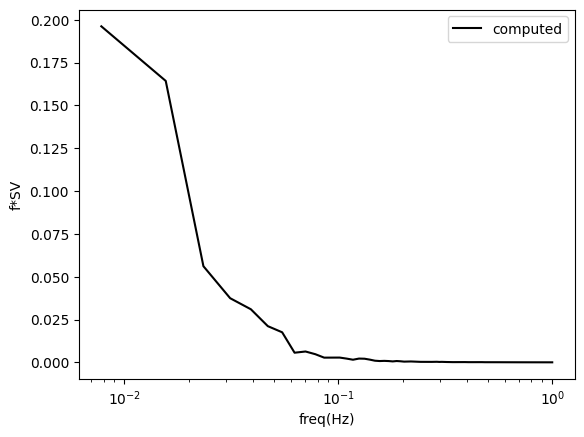

In [31]:
# from scipy.signal import welch
# fs = 0.1
# nperseg = 1
# ts = wind_field.get_uvwt()
# u = ts[0]
# v = ts[1]
# w = ts[2]
F, SV = welch(v[:, 9, 0], fs=2)# SU.mean()
# SU = np.mean(SU, axis=1)
# # f, SU = welch(u, fs=fs, nperseg=nperseg, noverlap=nperseg // 2) 
plt.figure()
plt.plot(F[1:], (F*SV.T)[1:], color='k', label="computed")
plt.xlabel("freq(Hz)")
plt.ylabel("f*SV")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

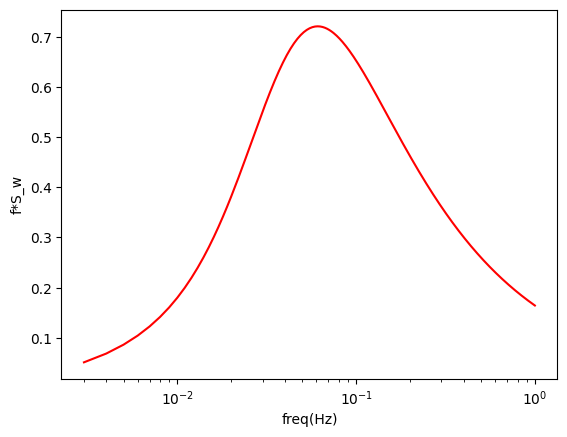

In [37]:
plt.figure()
plt.plot(f, (f*sw_ref.T), color='r')
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_w")
plt.xscale("log")
plt.show()